# Description

**Author:** Anna Luisa Hemshorn de Sánchez

**Affiliation:** (1) Department of Earth Sciences, VU Amsterdam, (2) Institute of Environmental Studies (IVM), VU Amsterdam, (3) Deltares

**Contact:** a.l.hemshorndesanchez@vu.nl

**Version:** V1

**Date:** Oct 02, 2025

**Description:** Data used in this notebook is obtained from: do Nascimento, T.V.M., Rudlang, J., Höge, M. et al. EStreams: An integrated dataset and catalogue of streamflow, hydro-climatic and landscape variables for Europe. _Sci Data_ 11, 879 (2024). https://doi.org/10.1038/s41597-024-03706-1

In this code we calculate statistics (mean, max and min) for streamflow, precipitation and temperature at annual (based on hydrological years) and seasonal scale. Then we normalize the streamflow and precipitation timeseries with their (overlapping) long-term mean.

# Import packages

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from scipy.stats import skew
from pathlib import Path
import gc

# Define file paths

In [2]:
# Get main directories
nb_dir = Path.cwd()
parent_dir = nb_dir.parent.parent.parent.parent
fp = parent_dir / "Data/Europe/estreams/EStreams_v1.3/"

# Input directories and filepaths
fp_gauges = fp / "streamflow_gauges/estreams_gauging_stations.csv"
fp_met = fp / "meteorology/" # contains: estreams_meteorology_{basin_id}.csv
fp_hydsig = fp / "hydroclimatic_signatures/estreams_hydrometeo_signatures.csv"
fp_shp_gau = fp / "shapefiles/estreams_gauging_stations.shp"
fp_shp_cat = fp / "shapefiles/estreams_catchments.shp"
fp_attr_stat = fp / "attributes/static_attributes/" # contains: estreams_{attribute_type}_attributes.csv
fp_attr_temp = fp / "attributes/temporal_attributes/" # contains: estreams_{attribute_type}_[time_scale].csv
fp_qidx_mon = fp / "streamflow_indices/monthly/" # contains: monthly_streamflow_{index}.csv
fp_qidx_season = fp / "streamflow_indices/seasonal/" # contains: seasonal_streamflow_{index}.csv
fp_qidx_week = fp / "streamflow_indices/weekly/" # contains: weekly_streamflow_{index}.csv
fp_qidx_year = fp / "streamflow_indices/yearly/" # contains: yearly_streamflow_{index}.csv

# Output directories
fp_gh = parent_dir / "Code/GitHub/streamflow_sensitivity_europe/"
fp_data_processed = fp_gh / "data/processed/" 
fp_tempstats = fp_data_processed / "02_temporal_stats/" 
fp_out_mon = fp_tempstats / "01_monthly/"
fp_out_hyr = fp_tempstats / "02_hyearly/"
fp_out_ssn = fp_tempstats / "03_seasonal/"
fp_figures = fp_gh / "figures/" 

# Read the filtered data 
To avoid confusioin on how the filtered catchment selection was done, here we only read in the csv with the basin_id that was created in another script.

In [3]:
basin_id_sel = pd.read_csv(fp_data_processed/"01_selection/basin_id_sel.csv", index_col=0)['basin_id'] #(str(fp_output+'selection/basin_id_sel.csv')
print('Amount of gauges: ', len(basin_id_sel))

Amount of gauges:  8307


In [4]:
%%time
## Read in monthly streamflow of selected catchments (SLOW CELL)

# Qmean
Qmean_mon = pd.read_csv(fp_qidx_mon/"monthly_streamflow_mean.csv", index_col=0, parse_dates=[0])[basin_id_sel]
Qmean_mon.index.name='index'
Qmean_mon = Qmean_mon[Qmean_mon.index>='1949-10-01'] # Crop the timeseries before 1950 since this is when met data starts
Qmean_mon.to_csv(fp_out_mon/"monthly_Qmean.csv")

# Q1dmax
Q1dmax_mon = pd.read_csv(fp_qidx_mon/"monthly_streamflow_max.csv", index_col=0, parse_dates=[0])[basin_id_sel]
Q1dmax_mon.index.name = 'index'
Q1dmax_mon = Q1dmax_mon[Q1dmax_mon.index>='1949-10-01'] # Crop the timeseries before 1950 since this is when met data starts
Q1dmax_mon.to_csv(fp_out_mon/"monthly_Q1dmax.csv")

# Q1dmin
Q1dmin_mon = pd.read_csv(fp_qidx_mon/"monthly_streamflow_min.csv", index_col=0, parse_dates=[0])[basin_id_sel]
Q1dmin_mon.index.name = 'index'
Q1dmin_mon = Q1dmin_mon[Q1dmin_mon.index>='1949-10-01'] # Crop the timeseries before 1950 since this is when met data starts
Q1dmin_mon.to_csv(fp_out_mon/"monthly_Q1dmin.csv")

# Q7dmin
Q7dmin_mon = pd.read_csv(fp_qidx_mon/"monthly_streamflow_min7days.csv",index_col=0, parse_dates=[0])[basin_id_sel]
Q7dmin_mon.index.name = 'index'
Q7dmin_mon = Q7dmin_mon[Q7dmin_mon.index>='1949-10-01'] # Crop the timeseries before 1950 since this is when met data starts
Q7dmin_mon.to_csv(fp_out_mon/"monthly_Q7dmin.csv")

CPU times: user 25.6 s, sys: 968 ms, total: 26.6 s
Wall time: 27 s


# Compute values per hydrological year

Resample Q and P, T and Ep variables to hydrological years.

In [5]:
MON_str = 'OCT' #'SEP' indicates that the analysis will be based on years that start in November and end in October

In [6]:
# Resample to Hydrological Years ('A-SEP') and calculate means
def compute_hyear_stat(df, stat, mon_str=MON_str, min_valid_months=11):
    """
    Compute hydrological year means for each basin_id. Hydrological year is from October to September ('A-SEP').

    Parameters:
    - df (pandas.DataFrame): Monthly data DataFrame.
    - min_valid_months (int): Minimum number of valid months required for the hydrological year mean.
    - stat (str): String of the statistic to be calculated ('mean', 'max' or 'min').
    
    Returns:
    - hyr_data(pandas.DataFrame): DataFrame of hydrological year means, indexed by hydrological year.
    """
    # Resample the data to hydrological years (A-SEP)
    if stat == 'mean':
        hyr_data = df.resample(str('A-'+mon_str)).mean()  # Mean per year, per basin_id #.apply(lambda x: x.mean(axis=0)
    elif stat == 'max':
        hyr_data = df.resample(str('A-'+mon_str)).max()  # Mean per year, per basin_id #.apply(lambda x: x.max(axis=0)
    elif stat == 'min':
        hyr_data = df.resample(str('A-'+mon_str)).min() # .apply(lambda x: x.min(axis=0)
    else:
        print('Input error: ', stat, ' does is not a valid input to the function.')
    
    # Identify invalid years based on valid months per year
    valid_months = df.resample(str('A-'+mon_str)).count()  # Count valid months per basin
    
    # Set years with fewer than min_valid_months valid months to NaN
    hyr_data[valid_months < min_valid_months] = np.nan
    
    return hyr_data

In [7]:
%%time
##---ONLY RE-RUN IF WE WANT TO UPDATE THE CALCULATION, ELSE READ OUTPUT IN---##

# Qmean
Qmean_hyr = compute_hyear_stat(Qmean_mon, stat='mean')
Qmean_hyr.to_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Qmean.csv")

# Q1dmax
Q1dmax_hyr = compute_hyear_stat(Q1dmax_mon, stat='max', min_valid_months=11)
Q1dmax_hyr.to_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q1dmax.csv")

# Q1dmin
Q1dmin_hyr = compute_hyear_stat(Q1dmin_mon, stat='min', min_valid_months=11)
Q1dmin_hyr.to_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q1dmin.csv")

# Q7dmin
Q7dmin_hyr = compute_hyear_stat(Q7dmin_mon, stat='min', min_valid_months=11)
Q7dmin_hyr.to_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q7dmin.csv")

CPU times: user 1.07 s, sys: 47.8 ms, total: 1.11 s
Wall time: 1.12 s


Now we load the meteorological data per catchment. The files are in daily resolution and we compute means, maxima and minima based on hydrological years. Weighted means are not necessary as each day has the same length. The files containd the following variables out of which we continue to work with the bold ones:

- **p_mean** [mm/d]
- **t_mean** [degC]
- t_min	[degC]
- t_max	[degC]
- sp_mean [hPa]	
- rh_mean [%]	
- ws_mean [m/s]	
- swr_mean [W/m^2]	
- pet_mean [mm/d]


To get the mean values per hydrological year (hydroyear) we compute the amount of days per hydroyear to calculate weighted means.

In [8]:
%%time
##------------------------------VERY SLOW CELL-------------------------------##
##---ONLY RE-RUN IF WE WANT TO UPDATE THE CALCULATION, ELSE READ OUTPUT IN---##

# The meteorological data is daily: weighting annual means is not necessary.

def process_met_hyr_data(basin_id, mon_str=MON_str, min_valid_days=330):
    """ Resamples monthly meteorological timeseries to hydrological years."""
    
    # Read the CSV file once for each basin
    bsn = pd.read_csv(fp_met/f'estreams_meteorology_{basin_id}.csv', 
                      index_col=[0], parse_dates=[0]) 
    #bsn.index = pd.to_datetime(bsn.index)
    
    # Define a function to process resampling and NaN filtering
    def resample_to_hyear(df, mean_or_max, tsh=31):
        # Convert single column (Series) to DataFrame to maintain structure
        df = df.to_frame()  # Ensures it remains a DataFrame

        # Resample to water year (Oct 1 - Sept 30)
        if mean_or_max == 'mean':
            hyear_resamp = df.resample(str('A-'+mon_str)).mean()
        elif mean_or_max == 'max':
            hyear_resamp = df.resample(str('A-'+mon_str)).max()
        else:
            print(str('KeyError: '+mean_or_max+' not a valid input to mean_or_max.'))
        
        # Count NaNs per hydroyear
        nan_count_per_year = df.resample("A-SEP").apply(lambda x: x.isna().sum())

        # Set hydroyear values to NaN where NaN count exceeds threshold
        hyear_resamp[nan_count_per_year > tsh] = np.nan

        return hyear_resamp

    # Resample for the different statistics
    Pmean_bsn = resample_to_hyear(bsn['p_mean'], mean_or_max='mean')
    Pmax_bsn = resample_to_hyear(bsn['p_mean'], mean_or_max='max')
    Epmean_bsn = resample_to_hyear(bsn['pet_mean'], mean_or_max='mean')
    Tmean_bsn = resample_to_hyear(bsn['t_mean'], mean_or_max='mean')

    # Rename columns for each computation to match the basin ID
    Pmean_bsn.rename(columns={'p_mean': basin_id}, inplace=True)
    Pmax_bsn.rename(columns={'p_mean': basin_id}, inplace=True)
    Epmean_bsn.rename(columns={'pet_mean': basin_id}, inplace=True)
    Tmean_bsn.rename(columns={'t_mean': basin_id}, inplace=True)
    
    return Pmean_bsn, Pmax_bsn, Epmean_bsn, Tmean_bsn

# Initialize empty DataFrames
Pmean_hyr = pd.DataFrame()
Pmax_hyr = pd.DataFrame()
Epmean_hyr = pd.DataFrame()
Tmean_hyr = pd.DataFrame()

# Loop through basin IDs, processing data efficiently
for basin in basin_id_sel:
    Pmean_bsn, Pmax_bsn, Epmean_bsn, Tmean_bsn = process_met_hyr_data(basin) #T_mean_bsn, T_max_bsn, 
    
    # Concatenate results for each statistic
    Pmean_hyr = pd.concat([Pmean_hyr, Pmean_bsn], axis=1)
    Pmax_hyr = pd.concat([Pmax_hyr, Pmax_bsn], axis=1)
    Epmean_hyr = pd.concat([Epmean_hyr, Epmean_bsn], axis=1)
    Tmean_hyr = pd.concat([Tmean_hyr, Tmean_bsn], axis=1)
    
Pmean_hyr.to_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Pmean.csv")
Pmax_hyr.to_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Pmax.csv")
Epmean_hyr.to_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Epmean.csv")
Tmean_hyr.to_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Tmean.csv")

CPU times: user 12min 2s, sys: 29.1 s, total: 12min 31s
Wall time: 12min 44s


In [9]:
## --- ONLY RE-RUN IF CODE NOT UPDATED AND WE ONLY WANT TO READ IN --- ##

## Read in hyearly met data streamflow of selected catchments
Pmean_hyr = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Pmean.csv", index_col=0, parse_dates=[0])
Pmax_hyr = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Pmax.csv", index_col=0, parse_dates=[0])
Epmean_hyr = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Epmean.csv", index_col=0, parse_dates=[0])
Tmean_hyr = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Tmean.csv", index_col=0, parse_dates=[0])

# Normalize the variables with their long term mean

*Since we also consider timeseries with long data gaps that have at least 120 months of non nan values in the entire timeseries, we need to consider this when calculating means of hydrological years. If more than a month in a hydrological year is a NaN value the mean for that year is set to nan as well.*

To normalize the data we will divide the time series by their long term mean of the corresponding catchment. We will only use the mean of those years where the two timeseries (Q and met. variable) overlap. As we are going to loop through each catchment and identify those catchments where there is an overlap we will combine this with the calculation of the elasticity.

In [10]:
def normalize_pairs(Q_df, met_df):
    """
    Normalize Q and met variable time series by their long-term mean, 
    but only considering years where both variables have valid (non-NaN) values.

    Parameters:
    - Q_df (pandas.DataFrame): DataFrame of Q values (basins x years).
    - met_df (pandas.DataFrame): DataFrame of corresponding meteorological values (basins x years).

    Returns:
    - norm_Q (pandas.DataFrame): Normalized Q values.
    - norm_met (pandas.DataFrame): Normalized met values (only for Ep, because T is not normalized).
    """
    # Ensure q and m have the same indices and columns
    if not Q_df.columns.equals(met_df.columns):
        raise ValueError("DataFrames must have the same columns.")

    # Extract year from the index
    #years = Q_df.index.year #years = Q_df.columns.astype(int)  # Convert to integers if they are not
    
    # Determine days in the year for each date
    days_in_year = pd.Series(365, index=Q_df.index) # days_in_year = pd.Series(365, index=years)
    leap_years = (Q_df.index.year % 4 == 0) & ((Q_df.index.year % 100 != 0) | (Q_df.index.year % 400 == 0))
    days_in_year[leap_years] = 366  # Assign 366 days to leap years
    
    # Identify valid years per location where both Q and met data are non-NaN
    mask = Q_df.notna() & met_df.notna()
    
    Q_wsum = (Q_df.mul(days_in_year, axis=0)).where(mask).sum()
    met_wsum = (met_df.mul(days_in_year, axis=0)).where(mask).sum()
    
    # Mask `days_in_year` by broadcasting it across columns and compute total valid days for each location
    days_in_year_masked = mask * days_in_year.to_numpy()[:, None]  
    total_valid_days = days_in_year_masked.sum()
    
    # Compute long-term mean for each location, using only valid years
    Q_mean_valid = Q_wsum / total_valid_days
    met_mean_valid = met_wsum / total_valid_days

    # Normalize the series
    norm_Q = (Q_df / Q_mean_valid).round(4)
    norm_met = (met_df / met_mean_valid).round(4)
    
    return norm_Q, norm_met

def normalize_Q_not_T(Q_df, met_df=Tmean_hyr):
    """
    Normalize Q and met variable time series by their long-term mean, 
    but only considering years where both variables have valid (non-NaN) values.

    Parameters:
    - Q_series (DataFrame): DataFrame of Q values (basins x years)
    - met_series (DataFrame): DataFrame of corresponding meteorological values (basins x years)

    Returns:
    - norm_Q (DataFrame): Normalized Q values for those years where met had non-nan values
    - met (DataFrame): Met values for those years where Q also had non-nan values
    """
    
    # Ensure q and m have the same indices and columns
    if not Q_df.columns.equals(met_df.columns):
        raise ValueError("DataFrames must have the same columns.")
        
    # Extract year from the index
    years = Q_df.index.year #years = Q_df.columns.astype(int)  # Convert to integers if they are not
    
    # Determine days in the year for each date
    days_in_year = pd.Series(365, index=Q_df.index) 
    leap_years = (years % 4 == 0) & ((years % 100 != 0) | (years % 400 == 0))
    days_in_year[leap_years] = 366  # Assign 366 days to leap years
    
    # Identify valid years per location where both Q and met data are non-NaN
    mask = Q_df.notna() & met_df.notna()
    met_masked = met_df.where(mask)
    
    Q_wsum = (Q_df.mul(days_in_year, axis=0)).where(mask).sum()
    met_wsum = (met_df.mul(days_in_year, axis=0)).where(mask).sum()
    
    # Mask `days_in_year` by broadcasting it across columns and compute total valid days for each location
    days_in_year_masked = mask * days_in_year.to_numpy()[:, None]  # Now this has the correct shape
    total_valid_days = days_in_year_masked.sum()
    
    # Compute long-term mean for each location, using only valid years
    Q_mean_valid = Q_wsum / total_valid_days
    met_mean_valid = met_wsum / total_valid_days

    # Normalize the series
    norm_Q = (Q_df / Q_mean_valid).round(4)
    met = met_masked.round(4)
    
    return norm_Q, met

In [11]:
%%time
##---ONLY RE-RUN IF WE WANT TO UPDATE THE CALCULATION, ELSE READ OUTPUT IN---##

## Q and P ----------------------------------------------------------------------------------------------
# Qmean, Pmean
Qmean_hyr_norm_QmeanPmean, Pmean_hyr_norm_QmeanPmean = normalize_pairs(Q_df=Qmean_hyr, met_df=Pmean_hyr) 
Qmean_hyr_norm_QmeanPmean.to_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Qmean_normalized_QmeanPmean.csv")
Pmean_hyr_norm_QmeanPmean.to_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Pmean_normalized_QmeanPmean.csv")

# Q1dmax, Pmean
Q1dmax_hyr_norm_Q1dmaxPmean, Pmean_hyr_norm_Q1dmaxPmean = normalize_pairs(Q_df=Q1dmax_hyr, met_df=Pmean_hyr)
Q1dmax_hyr_norm_Q1dmaxPmean.to_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q1dmax_normalized_Q1dmaxPmean.csv")
Pmean_hyr_norm_Q1dmaxPmean.to_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Pmean_normalized_Q1dmaxPmean.csv")

# Q1dmax, Pmax
Q1dmax_hyr_norm_Q1dmaxPmax, Pmax_hyr_norm_Q1dmaxPmax  = normalize_pairs(Q_df=Q1dmax_hyr, met_df=Pmax_hyr) 
Q1dmax_hyr_norm_Q1dmaxPmax.to_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q1dmax_normalized_Q1dmaxPmax.csv")
Pmax_hyr_norm_Q1dmaxPmax.to_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Pmax_normalized_Q1dmaxPmax.csv")

# Q1dmin, Pmean
Q1dmin_hyr_norm_Q1dminPmean, Pmean_hyr_norm_Q1dminPmean = normalize_pairs(Q_df=Q1dmin_hyr, met_df=Pmean_hyr)
Q1dmin_hyr_norm_Q1dminPmean.to_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q1dmin_normalized_Q1dminPmean.csv")
Pmean_hyr_norm_Q1dminPmean.to_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Pmean_normalized_Q1dminPmean.csv")

# Q7dmin, Pmean
Q7dmin_hyr_norm_Q7dminPmean, Pmean_hyr_norm_Q7dminPmean = normalize_pairs(Q_df=Q7dmin_hyr, met_df=Pmean_hyr)
Q7dmin_hyr_norm_Q7dminPmean.to_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q7dmin_normalized_Q7dminPmean.csv")
Pmean_hyr_norm_Q7dminPmean.to_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Pmean_normalized_Q7dminPmean.csv")


## Q and Ep ----------------------------------------------------------------------------------------------
# Qmean, Epmean
Qmean_hyr_norm_QmeanEpmean, Epmean_hyr_norm_QmeanEpmean = normalize_pairs(Q_df=Qmean_hyr, met_df=Epmean_hyr) 
Qmean_hyr_norm_QmeanEpmean.to_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Qmean_normalized_QmeanEpmean.csv")
Epmean_hyr_norm_QmeanEpmean.to_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Epmean_normalized_QmeanEpmean.csv")

# Q1dmax, Epmean
Q1dmax_hyr_norm_Q1dmaxEpmean, Epmean_hyr_norm_Q1dmaxEpmean = normalize_pairs(Q_df=Q1dmax_hyr, met_df=Epmean_hyr)
Q1dmax_hyr_norm_Q1dmaxEpmean.to_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q1dmax_normalized_Q1dmaxEpmean.csv")
Epmean_hyr_norm_Q1dmaxEpmean.to_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Epmean_normalized_Q1dmaxEpmean.csv")

# Q1dmin, Epmean
Q1dmin_hyr_norm_Q1dminEpmean, Epmean_hyr_norm_Q1dminEpmean = normalize_pairs(Q_df=Q1dmin_hyr, met_df=Epmean_hyr)
Q1dmin_hyr_norm_Q1dminEpmean.to_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q1dmin_normalized_Q1dminEpmean.csv")
Epmean_hyr_norm_Q1dminEpmean.to_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Epmean_normalized_Q1dminEpmean.csv")

# Q7dmin, Epmean
Q7dmin_hyr_norm_Q7dminEpmean, Epmean_hyr_norm_Q7dminEpmean = normalize_pairs(Q_df=Q7dmin_hyr, met_df=Epmean_hyr)
Q7dmin_hyr_norm_Q7dminEpmean.to_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q7dmin_normalized_Q7dminEpmean.csv")
Epmean_hyr_norm_Q7dminEpmean.to_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Epmean_normalized_Q7dminEpmean.csv")


## Q and T ----------------------------------------------------------------------------------------------
## T itself should not be normalized, but Q can be normalized over the period where Tmean has values
# Qmean, Tmean
Qmean_hyr_norm_QmeanTmean, Tmean_hyr_QmeanTmean = normalize_Q_not_T(Q_df=Qmean_hyr, met_df=Tmean_hyr) 
Qmean_hyr_norm_QmeanTmean.to_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Qmean_normalized_QmeanTmean.csv")
Tmean_hyr_QmeanTmean.to_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Tmean_QmeanTmean.csv")

# Q1dmax, Tmean
Q1dmax_hyr_norm_Q1dmaxTmean, Tmean_hyr_Q1dmaxTmean = normalize_Q_not_T(Q_df=Q1dmax_hyr, met_df=Tmean_hyr)
Q1dmax_hyr_norm_Q1dmaxTmean.to_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q1dmax_normalized_Q1dmaxTmean.csv")
Tmean_hyr_Q1dmaxTmean.to_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Tmean_Q1dmaxTmean.csv")

# Q1dmin, Tmean
Q1dmin_hyr_norm_Q1dminTmean, Tmean_hyr_Q1dminTmean = normalize_Q_not_T(Q_df=Q1dmin_hyr, met_df=Tmean_hyr)
Q1dmin_hyr_norm_Q1dminTmean.to_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q1dmin_normalized_Q1dminTmean.csv")
Tmean_hyr_Q1dminTmean.to_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Tmean_Q1dminTmean.csv")

# Q7dmin, Tmean
Q7dmin_hyr_norm_Q7dminTmean, Tmean_hyr_Q7dminTmean = normalize_Q_not_T(Q_df=Q7dmin_hyr, met_df=Tmean_hyr)
Q7dmin_hyr_norm_Q7dminTmean.to_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q7dmin_normalized_Q7dminTmean.csv")
Tmean_hyr_Q7dminTmean.to_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Tmean_Q7dminTmean.csv")

CPU times: user 4.68 s, sys: 199 ms, total: 4.88 s
Wall time: 4.93 s


Let's check how symmetrical annual normalized Q and P are distributed.

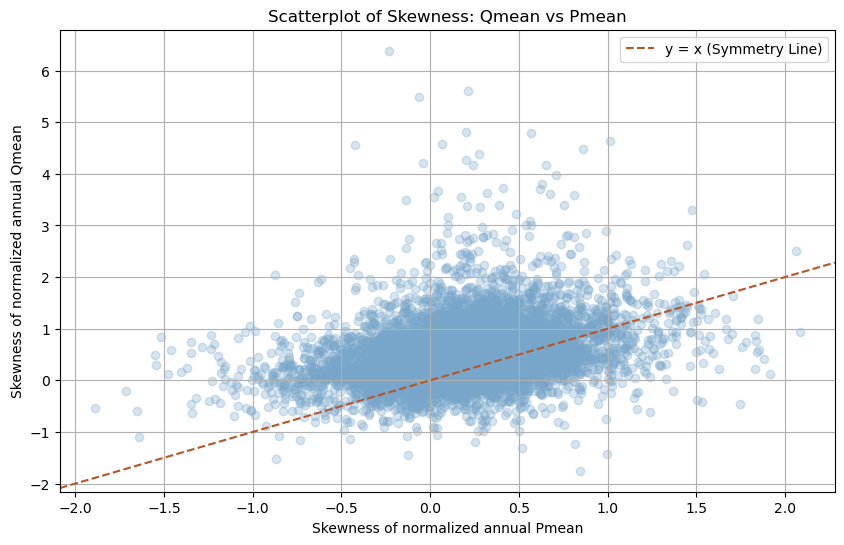

,mean,median,std_dev,min,max,percentile_25,percentile_75
Pmean_hyear,0.177363,0.166226,0.408624,-1.888389,2.082231,-0.073813,0.415385
Qmean_hyr,0.508243,0.433998,0.577312,-1.750925,6.385203,0.150911,0.778614


In [12]:
# Function to compute skewness only for rows where both x and y are non-NaN
def compute_skew(pair):
    x, y = pair
    mask = x.notna() & y.notna()  # Filter for non-NaN values
    return skew(x[mask]), skew(y[mask])

# Apply the function across all columns
skews = Pmean_hyr_norm_QmeanPmean.columns.to_series().apply(lambda col: compute_skew((Pmean_hyr_norm_QmeanPmean[col], 
                                                                            Qmean_hyr_norm_QmeanPmean[col])))

# Split the results into separate skewness for A and B
skew_Pmean_hyr = skews.apply(lambda x: x[0])
skew_Qmean_hyr = skews.apply(lambda x: x[1])

# Scatter plot of the P and Q skewness distribution
plt.figure(figsize=(10, 6))
plt.scatter(skew_Pmean_hyr, skew_Qmean_hyr, alpha=0.3, color='#77A6CA', edgecolor='#77A6CA')
plt.axline((0, 0), slope=1, color='#B95427', linestyle='--', label="y = x (Symmetry Line)")
plt.title("Scatterplot of Skewness: Qmean vs Pmean")
plt.xlabel("Skewness of normalized annual Pmean")
plt.ylabel("Skewness of normalized annual Qmean")
plt.legend()
plt.grid(True)
plt.savefig(fp_figures/f"02_temporal_stats/01_hyearly/01_skewness/hyear_A-{MON_str}_scatterplot_skew_Qmean_Pmean.png")
plt.show()

# Summarize skewness for A
summary_Pmean_hyr = {
    "mean": skew_Pmean_hyr.mean(),
    "median": skew_Pmean_hyr.median(),
    "std_dev": skew_Pmean_hyr.std(),
    "min": skew_Pmean_hyr.min(),
    "max": skew_Pmean_hyr.max(),
    "percentile_25": skew_Pmean_hyr.quantile(0.25),
    "percentile_75": skew_Pmean_hyr.quantile(0.75)
}

# Summarize skewness for B
summary_Qmean_hyr = {
    "mean": skew_Qmean_hyr.mean(),
    "median": skew_Qmean_hyr.median(),
    "std_dev": skew_Qmean_hyr.std(),
    "min": skew_Qmean_hyr.min(),
    "max": skew_Qmean_hyr.max(),
    "percentile_25": skew_Qmean_hyr.quantile(0.25),
    "percentile_75": skew_Qmean_hyr.quantile(0.75)
}

# Combine summaries into a DataFrame for easier comparison
skew_summary = pd.DataFrame([summary_Pmean_hyr, summary_Qmean_hyr], index=['Pmean_hyear', 'Qmean_hyr'])
skew_summary

It looks like both variables are on average highly symmetrical. Within the the 25th and 75th percentile there are still between highly symmetrical and moderatly skewed (Q).

# Compute variables per season

We use the same season for all catchments **May-Oct** and **Nov-Apr**. These seasons were chosen was based on the mdoy maps for maxium and minimum flow.  

In [13]:
mon_dict = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 
    6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 
    11: 'Nov', 12: 'Dec'
}

def process_basin(basin, hfs, lfs, data_dir):
    """
    Reads a single basin file and returns seasonal data.
    
    Parameters:
    - basin (str): Name of the basin_id
    - hfs (list): List of numbers corresponding to the high flow season
    - lfs (list): List of numbers corresponding to the low flow season
    
    Returns:
    - basin (str): Name of the basin_id.
    - met_mon_hfs (pandas.DataFrame): Dataframe of all locations.
    - met_mon_lfs (pandas.DataFrame): Dataframe of all locations.
    """
    fp = os.path.join(data_dir, f'estreams_meteorology_{basin}.csv')
    
    # Read only required columns
    met_mon = pd.read_csv(fp, index_col=[0], parse_dates=[0], usecols=['date','p_mean', 'pet_mean', 't_mean', 't_max', 't_min'])
    if not isinstance(met_mon.index, pd.DatetimeIndex):
        met_mon.index = pd.to_datetime(met_mon.index)  # Ensure correct index
    
    # Handle high-flow season (HFS)
    if hfs[0] > hfs[-1]:  # HFS spans two calendar years
        hfs_prev = met_mon[met_mon.index.month >= hfs[0]].copy()
        hfs_prev.index += pd.DateOffset(years=1)  # Shift to next year
        hfs_curr = met_mon[met_mon.index.month <= hfs[-1]]
        met_mon_hfs = pd.concat([hfs_prev, hfs_curr])
    else:
        met_mon_hfs = met_mon[met_mon.index.month.isin(hfs)]
    
    # LFS Selection
    met_mon_lfs = met_mon[met_mon.index.month.isin(lfs)]
    
    return basin, met_mon_hfs, met_mon_lfs


def aggregate_valid_years(df, stat, min_valid_months=4):
    """ Mask years with fewer than `min_valid_months` of valid (non-NaN) data. """
    
    valid_counts = df.resample('A').count()  # Count valid months per year
    mask = valid_counts >= min_valid_months  # Keep only years with at least 4 valid months
    
    # Apply the mask per basin and year
    df_resampled = df.resample('A').agg(stat) # Aggregate by year first
    df_resampled[~mask] = np.nan
    
    return df_resampled


def get_met_seasons(hfs, lfs, basin_ids=basin_id_sel, min_valid_months=4,
                    data_dir=fp_met, output_dir=fp_out_ssn, 
                    n_jobs=8):
    """
    Processes all basins and calculates seasonal statistics efficiently.
    
    Parameters:
    - hfs (list): List of numbers corresponding to the high flow season.
    - lfs (list): List of numbers corresponding to the low flow season.
    - basin_ids (list): List of the strings of the selected basin_ids.
    - n_jobs (int): Describes the amount of parallel processes (CPU cores used).
    
    Returns: DataFrames of different climate variables for the cold season (hfs) and the warm season (lfs)
    - p_mean_yr_hfs (pandas.DataFrame)
    - p_mean_yr_lfs (pandas.DataFrame)
    - pet_mean_yr_hfs (pandas.DataFrame)
    - pet_mean_yr_lfs (pandas.DataFrame)
    - tmean_mean_yr_hfs (pandas.DataFrame)
    - tmean_mean_yr_lfs (pandas.DataFrame)
    - p_max_yr_hfs (pandas.DataFrame)
    - p_max_yr_lfs (pandas.DataFrame)
    """
    
    # Parallel processing of basin files
    results = Parallel(n_jobs=n_jobs)(delayed(process_basin)(basin, hfs, lfs, data_dir) for basin in basin_ids)
    
    # Store results in dictionaries
    p_hfs, p_lfs = {}, {}
    pet_hfs, pet_lfs = {}, {}
    tmean_hfs, tmean_lfs = {}, {}
    tmax_hfs, tmax_lfs = {}, {}
    tmin_hfs, tmin_lfs = {}, {}
    
    for basin, met_hfs, met_lfs in results:
        p_hfs[basin] = met_hfs['p_mean']
        p_lfs[basin] = met_lfs['p_mean']
        pet_hfs[basin] = met_hfs['pet_mean']
        pet_lfs[basin] = met_lfs['pet_mean']
        tmean_hfs[basin] = met_hfs['t_mean']
        tmean_lfs[basin] = met_lfs['t_mean']
        tmax_hfs[basin] = met_hfs['t_max']
        tmax_lfs[basin] = met_lfs['t_max']
        tmin_hfs[basin] = met_hfs['t_min']
        tmin_lfs[basin] = met_lfs['t_min']
    
    # Convert to DataFrames (bulk operation)
    p_mon_hfs = pd.DataFrame(p_hfs)
    p_mon_lfs = pd.DataFrame(p_lfs)
    pet_mon_hfs = pd.DataFrame(pet_hfs)
    pet_mon_lfs = pd.DataFrame(pet_lfs)
    tmean_mon_hfs = pd.DataFrame(tmean_hfs)
    tmean_mon_lfs = pd.DataFrame(tmean_lfs)
    tmax_mon_hfs = pd.DataFrame(tmax_hfs)
    tmax_mon_lfs = pd.DataFrame(tmax_lfs)
    tmin_mon_hfs = pd.DataFrame(tmin_hfs)
    tmin_mon_lfs = pd.DataFrame(tmin_lfs)
    
    print('DataFrames created. Computing statistics...')
    
    # Compute yearly statistics
    def save_stat(df, stat, var_name, season):
        """ Compute and save seasonal statistics with missing year filtering. """
        
        result = aggregate_valid_years(df, stat, min_valid_months=4)  # Already resampled to 'A'

        # Save the file
        result.to_csv(os.path.join(output_dir, f"{var_name}_{stat}_{season}_{mon_dict[hfs[0]]}{mon_dict[hfs[-1]]}.csv"))
        
        return result
        
    # Save the mean for both seasons
    p_mean_yr_hfs = save_stat(p_mon_hfs, 'mean', 'Pmean', 'hfs')
    p_mean_yr_lfs = save_stat(p_mon_lfs, 'mean', 'Pmean', 'lfs')
    
    pet_mean_yr_hfs = save_stat(pet_mon_hfs, 'mean', 'Epmean', 'hfs')
    pet_mean_yr_lfs = save_stat(pet_mon_lfs, 'mean', 'Epmean', 'lfs')

    tmean_mean_yr_hfs = save_stat(tmean_mon_hfs, 'mean', 'Tmean', 'hfs')
    tmean_mean_yr_lfs = save_stat(tmean_mon_lfs, 'mean', 'Tmean', 'lfs')

    # Save the max only for HFS
    p_max_yr_hfs = save_stat(p_mon_hfs, 'max', 'Pmean', 'hfs')
    #pet_max_yr_hfs = save_stat(pet_mon_hfs, 'max', 'Epmean', 'hfs')
    #t_max_yr_hfs = save_stat(tmax_mon_hfs, 'max', 'Tmax', 'hfs')
    #t_min_yr_hfs = save_stat(tmax_mon_hfs, 'max', 'Tmin', 'hfs')

    # Save the min only for LFS
    p_max_yr_lfs = save_stat(p_mon_lfs, 'max', 'Pmean', 'lfs')
    p_min_yr_lfs = save_stat(p_mon_lfs, 'min', 'Pmean', 'lfs')
    #pet_min_yr_lfs = save_stat(pet_mon_lfs, 'min', 'Epmean', 'lfs')
    #t_max_yr_lfs = save_stat(tmin_mon_lfs, 'min', 'Tmax', 'lfs')
    #t_min_yr_lfs = save_stat(tmin_mon_lfs, 'min', 'Tmin', 'lfs')
    
    print('File export finished.')
    
    return p_mean_yr_hfs, p_mean_yr_lfs, pet_mean_yr_hfs, pet_mean_yr_lfs, tmean_mean_yr_hfs, tmean_mean_yr_lfs, p_max_yr_hfs, p_max_yr_lfs

In [14]:
def get_Q_yr_hfs(hfs, min_valid_months, Q_mon, mean_or_max):
    """ Resamples monthly Q timeseries to seasonal timeseries of the cold season (hfs). """
    
    Q_mon_hfs = pd.DataFrame()
    
    # Handle warm season (HFS)
    if hfs[0] > hfs[-1]:  # HFS spans two calendar years (e.g., Nov-Apr: [11,12,1,2,3,4])
        # Select months > hfs[-1] (e.g., Oct-Dec) and shift indices forward
        hfs_prev = Q_mon[(Q_mon.index.month >= hfs[0])]
        hfs_prev.index += pd.DateOffset(years=1)  # Shift to the next year
        
        # Select months ≤ hfs[-1] (e.g., Jan-Mar)
        hfs_curr = Q_mon[Q_mon.index.month <= hfs[-1]]
        
        # Concatenate the two parts
        Q_mon_hfs = pd.concat([hfs_prev, hfs_curr]).sort_index() # Sort by index

    else:  # HFS within the same calendar year (e.g., Jan-Jun)
        Q_mon_hfs = Q_mon[Q_mon.index.month.isin(hfs)].sort_index() # Sort by index
        
    # Convert index to DateTimeIndex
    Q_mon_hfs.index = pd.to_datetime(Q_mon_hfs.index)
    
    # Resample to get yearly max/mean values
    if mean_or_max == 'mean':
        Q_yr_hfs = Q_mon_hfs.resample('A').mean()
    elif mean_or_max =='max':
        Q_yr_hfs = Q_mon_hfs.resample('A').max()
    elif mean_or_max =='min':
        Q_yr_hfs = Q_mon_hfs.resample('A').min()
        
    # Identify invalid years based on valid months per year
    valid_months = Q_mon_hfs.resample('A').count()  # Count valid months per basin
    
    # Set years with fewer than min_valid_months valid months to NaN
    Q_yr_hfs[valid_months < min_valid_months] = np.nan
    
    return Q_yr_hfs

def get_Q_yr_lfs(lfs, min_valid_months, Q_mon, mean_or_min):
    """ Resamples monthly Q timeseries to seasonal timeseries of the warm season (lfs). """
    
    Q_mon_lfs = pd.DataFrame()
    
    # LFS are always within the same calendar year
    Q_mon_lfs = Q_mon[Q_mon.index.month.isin(lfs)].sort_index() # Sort by index
        
    # Convert index to DateTimeIndex
    Q_mon_lfs.index = pd.to_datetime(Q_mon_lfs.index)
    
    # Resample to get yearly max/mean values
    if mean_or_min == 'mean':
        Q_yr_lfs = Q_mon_lfs.resample('A').mean()
    elif mean_or_min == 'max':
        Q_yr_lfs = Q_mon_lfs.resample('A').max()
    elif mean_or_min == 'min':
        Q_yr_lfs = Q_mon_lfs.resample('A').min()
        
    # Identify invalid years based on valid months per year
    valid_months = Q_mon_lfs.resample('A').count()  # Count valid months per basin
    
    # Set years with fewer than min_valid_months valid months to NaN
    Q_yr_lfs[valid_months < min_valid_months] = np.nan
    
    return Q_yr_lfs

In [15]:
def split_Q_seasons(hfs, lfs, min_valid_months=4, Q_dfs=[Qmean_mon, Q1dmax_mon, Q7dmin_mon]):
    """""""""
    Extracts the normalized maximum Qmax based on max of the months listed in the highflow 
    season list (hfs) and the normalized minimum Qmin of the min of the months listed in the list for the 
    low flow season (lfs). hfs can start in the previous year but lfs is assumed to be only in the current year. 
    
    Parameters:
    - hfs (list): Array of the months of the hight-flow season ([1,2,3,4,5,6])
    - lfs (list): Array of the months of the low-flow season ([7,8,9,10,11,12])
    - min_valid_months (int): Number of minimum non nan months per season to compute means or extremes for that season and catchment.
    - Q_dfs (List): List of the three arrays of monthly streamflow data ([Qmean_mon, Q1dmax_mon, Q7dmin, mon])
    
    Returns:
    - Qmean_yr_hfs (pandas.DataFrame): Dataframe of Qmean for the cold season.
    - Qmean_yr_lfs (pandas.DataFrame): Dataframe of Qmean for the warm season.
    - Qmax_yr_hfs (pandas.DataFrame): Dataframe of Qmax for the cold season.
    - Qmax_yr_lfs (pandas.DataFrame): Dataframe of Qmax for the warm season.
    - Qmin_yr_hfs (pandas.DataFrame): Dataframe of Qmin for the cold season.
    - Qmin_yr_lfs (pandas.DataFrame): Dataframe of Qmin for the warm season.
    """""""""
    
    if Q_dfs is None:
        raise ValueError("Q_dfs must be a list of three DataFrames: [Qmean_mon, Qmax_mon, Qmin_mon]")

    # Unpack the dataframes
    Q_mon_mean, Q_mon_max, Q_mon_min = Q_dfs  
    
    Qmean_yr_hfs = get_Q_yr_hfs(hfs=hfs, min_valid_months=min_valid_months, Q_mon=Q_mon_mean, mean_or_max='mean')
    Qmean_yr_lfs = get_Q_yr_lfs(lfs=lfs, min_valid_months=min_valid_months, Q_mon=Q_mon_mean, mean_or_min='mean')
    
    Qmax_yr_hfs = get_Q_yr_hfs(hfs=hfs, min_valid_months=min_valid_months, Q_mon=Q_mon_max, mean_or_max='max')
    Qmax_yr_lfs = get_Q_yr_lfs(lfs=lfs, min_valid_months=min_valid_months, Q_mon=Q_mon_max, mean_or_min='max')

    Qmin_yr_hfs = get_Q_yr_hfs(hfs=hfs, min_valid_months=min_valid_months, Q_mon=Q_mon_min, mean_or_max='min')
    Qmin_yr_lfs = get_Q_yr_lfs(lfs=lfs, min_valid_months=min_valid_months, Q_mon=Q_mon_min, mean_or_min='min')

    Qmean_yr_hfs.to_csv(fp_out_ssn/f"Qmean_hfs_{mon_dict[hfs[0]]}{mon_dict[hfs[-1]]}.csv")
    Qmean_yr_lfs.to_csv(fp_out_ssn/f"Qmean_lfs_{mon_dict[lfs[0]]}{mon_dict[lfs[-1]]}.csv")
    Qmax_yr_hfs.to_csv(fp_out_ssn/f"Qmax_hfs_{mon_dict[hfs[0]]}{mon_dict[hfs[-1]]}.csv")
    Qmax_yr_lfs.to_csv(fp_out_ssn/f"Qmax_lfs_{mon_dict[lfs[0]]}{mon_dict[lfs[-1]]}.csv")
    Qmin_yr_hfs.to_csv(fp_out_ssn/f"Qmin_hfs_{mon_dict[hfs[0]]}{mon_dict[hfs[-1]]}.csv")
    Qmin_yr_lfs.to_csv(fp_out_ssn/f"Qmin_lfs_{mon_dict[lfs[0]]}{mon_dict[lfs[-1]]}.csv")

    return Qmean_yr_hfs , Qmean_yr_lfs, Qmax_yr_hfs, Qmax_yr_lfs, Qmin_yr_hfs, Qmin_yr_lfs

# Normalize seasonal met data and annual flow

In [16]:
%%time

HFS = [11,12,1,2,3,4]
LFS = [5,6,7,8,9,10]

met_seasons = get_met_seasons(hfs=HFS, lfs=LFS, basin_ids=basin_id_sel, min_valid_months=4,           
                              data_dir=fp_met, output_dir=fp_out_ssn, 
                              n_jobs=8)

p_mean_yr_hfs, p_mean_yr_lfs, pet_mean_yr_hfs, pet_mean_yr_lfs, tmean_mean_yr_hfs, tmean_mean_yr_lfs, p_max_yr_hfs, p_max_yr_lfs = met_seasons
#Qmean_yr_hfs , Qmean_yr_lfs, Qmax_yr_hfs, Qmax_yr_lfs, Qmin_yr_hfs, Qmin_yr_lfs = split_Q_seasons(hfs=HFS, lfs=LFS, min_valid_months=4, Q_dfs=[Qmean_mon, Q1dmax_mon, Q7dmin_mon])

DataFrames created. Computing statistics...
File export finished.
CPU times: user 18.1 s, sys: 20.6 s, total: 38.7 s
Wall time: 2min 3s


In [17]:
def sum_days(months):
    days_in_month = {1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6: 30, 
                     7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31}
    return sum(days_in_month[m] for m in months)

def normalize_seasonal_pairs(Q_df, met_df, met_str, season_list):
    """
    Normalize annual Q and seasonal met variable time series by their long-term mean, 
    but only considering years where both variables have valid (non-NaN) values.

    Parameters:
    - Q_df (pandas.DataFrame): DataFrame of annual Q values (basins x years).
    - met_df (pandas.DataFrame): DataFrame of corresponding seasonal meteorological values (basins x years).
    - met_str (str): Name of the meteorological variables that is analysed e.g. 'Pmean', Epmean' or 'Tmean'.
    - season_list (list): List of the seasons e.g. [11,12,1,2,3,4].

    Returns:
    - norm_Q (pandas.DataFrame): Normalized Q of valid years.
    - norm_met (pandas.DataFrame): Normalized met of valid seasons.
    """
    
    # Ensure q and m have the same indices and columns
    if not Q_df.columns.equals(met_df.columns):
        raise ValueError("DataFrames must have the same columns.")

    met_df.index = met_df.index.year.astype(str) + "-10-31"
    met_df.index = pd.to_datetime(met_df.index)
    #met_df.index -= pd.DateOffset(months=2)  # Shift to the next year
        
    # Identify valid years per location where both Q and met data are non-NaN
    mask = Q_df.notna() & met_df.notna()
    
    #Q_masked = Q_df.where(mask)
    met_masked = met_df.where(mask)
    
    # Extract year from the index
    years = Q_df.index.year #years = Q_df.columns.astype(int)  # Convert to integers if they are not
    leap_years = (years % 4 == 0) & ((years % 100 != 0) | (years % 400 == 0))
        
    days_in_years = pd.Series(365, index=Q_df.index) # days_in_year = pd.Series(365, index=years)
    days_in_years[leap_years] = 366
    
    # Identify valid years per location where both Q and met data are non-NaN
    mask = Q_df.notna() & met_df.notna()

    Q_wsum = (Q_df.mul(days_in_years, axis=0)).where(mask).sum()
    
    # Mask `days_in_season` by broadcasting it across columns and compute total valid days for each location
    days_in_years_masked = mask * days_in_years.to_numpy()[:, None]
    total_valid_days = days_in_years_masked.sum()

    # Compute long-term mean for each location, using only valid years
    Q_mean_valid = (Q_wsum / total_valid_days).round(4)
        
    # Normalize Q
    Q_hyr_norm = (Q_df / Q_mean_valid).round(4)
    
    if 2 in season_list:
        # Determine days in the season for each date
        days_in_season = pd.Series(sum_days(season_list), index=Q_df.index) # days_in_year = pd.Series(365, index=years)
        days_in_season[leap_years] = sum_days(season_list)+1  # Assign +1 day to leap years
        
        met_wsum = (met_df.mul(days_in_season, axis=0)).where(mask).sum()

        # Mask `days_in_season` by broadcasting it across columns and compute total valid days for each location
        days_in_season_masked = mask * days_in_season.to_numpy()[:, None]
        total_valid_days = days_in_season_masked.sum()

        # Compute long-term mean for each location, using only valid years
        met_mean_valid = met_wsum / total_valid_days
        
    else:
        # Compute long-term mean for each location, using only valid years
        met_mean_valid = met_df.where(mask).mean(skipna=True)
    
    
    # Check whether to normalize met
    if met_str.startswith('T'): # T timeseries are not normalised
        met_season = met_masked.round(4)
    
    else: # P and Ep timeseries are normalised
        met_season = (met_masked / met_mean_valid).round(4)
    
    return Q_hyr_norm, met_season

In [18]:
def save_normalized_ts(Q_df, met_df, Q_str, met_str, season_str, season_list):
    """ Saves normalised Q and not normalised T timeseries in DataFrames. """
    
    Q_hyr_norm, met_season = normalize_seasonal_pairs(Q_df, met_df, met_str, season_list) # met_norm also includes T which is not normalized
    
    Q_hyr_norm.to_csv(fp_out_ssn/f"hyr{Q_str}_for-{season_str}-{mon_dict[season_list[0]]}{mon_dict[season_list[-1]]}-{met_str}_normalized.csv")
    
    if met_str.startswith('T'): # temperature timeseries are not normalised
        met_season.to_csv(fp_out_ssn/f"{season_str}-{mon_dict[season_list[0]]}{mon_dict[season_list[-1]]}-{met_str}_for-hyr-{Q_str}.csv")
    else:
        met_season.to_csv(fp_out_ssn/f"{season_str}-{mon_dict[season_list[0]]}{mon_dict[season_list[-1]]}-{met_str}_for-hyr{Q_str}_normalized.csv")
    
    return Q_hyr_norm, met_season

In [19]:
%%time
# HFS cold-season mean
save_normalized_ts(Q_df=Qmean_hyr, met_df=p_mean_yr_hfs, Q_str='Qmean', met_str='Pmean', season_str='hfs', season_list=HFS)
save_normalized_ts(Q_df=Qmean_hyr, met_df=pet_mean_yr_hfs, Q_str='Qmean', met_str='Epmean', season_str='hfs', season_list=HFS)
save_normalized_ts(Q_df=Qmean_hyr, met_df=tmean_mean_yr_hfs, Q_str='Qmean', met_str='Tmean', season_str='hfs', season_list=HFS)
save_normalized_ts(Q_df=Qmean_hyr, met_df=p_max_yr_hfs, Q_str='Qmean', met_str='Pmax', season_str='hfs', season_list=HFS)

# LFS warm-season mean
save_normalized_ts(Q_df=Qmean_hyr, met_df=p_mean_yr_lfs, Q_str='Qmean', met_str='Pmean', season_str='lfs', season_list=LFS)
save_normalized_ts(Q_df=Qmean_hyr, met_df=pet_mean_yr_lfs, Q_str='Qmean', met_str='Epmean', season_str='lfs', season_list=LFS)
save_normalized_ts(Q_df=Qmean_hyr, met_df=tmean_mean_yr_lfs, Q_str='Qmean', met_str='Tmean', season_str='lfs', season_list=LFS)


# HFS cold-season max flow with mean met variable
QmaxPmean_hfs = save_normalized_ts(Q_df=Q1dmax_hyr, met_df=p_mean_yr_hfs, Q_str='Qmax', met_str='Pmean', season_str='hfs', season_list=HFS)
QmaxEpmean_hfs = save_normalized_ts(Q_df=Q1dmax_hyr, met_df=pet_mean_yr_hfs, Q_str='Qmax', met_str='Epmean', season_str='hfs', season_list=HFS)
QmaxTmean_hfs = save_normalized_ts(Q_df=Q1dmax_hyr, met_df=tmean_mean_yr_hfs, Q_str='Qmax', met_str='Tmean', season_str='hfs', season_list=HFS)
QminPmean_hfs = save_normalized_ts(Q_df=Q7dmin_hyr, met_df=p_mean_yr_hfs, Q_str='Qmin', met_str='Pmean', season_str='hfs', season_list=HFS)

QmaxTmean_lfs = save_normalized_ts(Q_df=Q1dmax_hyr, met_df=tmean_mean_yr_lfs, Q_str='Qmax', met_str='Tmean', season_str='lfs', season_list=LFS)

QmaxPmax_hfs = save_normalized_ts(Q_df=Q1dmax_hyr, met_df=p_max_yr_hfs, Q_str='Qmax', met_str='Pmax', season_str='hfs', season_list=HFS)
QmaxPmax_lfs = save_normalized_ts(Q_df=Q1dmax_hyr, met_df=p_max_yr_lfs, Q_str='Qmax', met_str='Pmax', season_str='lfs', season_list=LFS)


# LFS warm-season minflow with mean met variable
QminPmean_lfs = save_normalized_ts(Q_df=Q7dmin_hyr, met_df=p_mean_yr_lfs, Q_str='Qmin', met_str='Pmean', season_str='lfs', season_list=LFS)
QminEpmean_lfs = save_normalized_ts(Q_df=Q7dmin_hyr, met_df=pet_mean_yr_lfs, Q_str='Qmin', met_str='Epmean', season_str='lfs', season_list=LFS)
QminTmean_lfs = save_normalized_ts(Q_df=Q7dmin_hyr, met_df=tmean_mean_yr_lfs, Q_str='Qmin', met_str='Tmean', season_str='lfs', season_list=LFS)

QminTmean_hfs = save_normalized_ts(Q_df=Q7dmin_hyr, met_df=tmean_mean_yr_hfs, Q_str='Qmin', met_str='Tmean', season_str='hfs', season_list=HFS)

QmaxPmean_lfs = save_normalized_ts(Q_df=Q1dmax_hyr, met_df=p_mean_yr_lfs, Q_str='Qmax', met_str='Pmean', season_str='lfs', season_list=LFS)

CPU times: user 7.14 s, sys: 353 ms, total: 7.49 s
Wall time: 7.88 s
